# Pre-process Hindi hate-speech
This notebook does all the pre-processing on the Hindi hate-speech data, including:
- Removing user-tagging,
- Removing stopwords,
- Removing punctuations,
- Removing urls,
- Replacing numbers,
- Forming phrases (disabled),

### Input:
    Train and test Hindi hatespeech datasets.
### Output:
    csv-files containing the ready-to-train and ready-to-test data

# Import libraries

In [1]:
# Imports
import re
import string
import json
from datetime import datetime
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

device = 'cpu'

import random

np.random.seed(345)
random.seed(456)

## Load data

In [2]:
hindi_train_df = pd.read_csv('../../data/hindi_hatespeech.tsv', sep='\t')
hindi_test_df = pd.read_csv('../../data/hasoc2019_hi_test_gold_2919.tsv', sep='\t')

In [3]:
train_sentences = hindi_train_df['text']
test_sentences = hindi_test_df['text']

## Clean texts

In [4]:
# remove user taggings
user_tag_pattern = re.compile(r'\@\w*')
def remove_tagging(sentence):
    return re.sub(user_tag_pattern, ' ', sentence)

# remove punctuations and urls
http_re = re.compile('http://[^ ]*')
https_re = re.compile('https://[^ ]*')
punctuation = string.punctuation[:2] + string.punctuation[3:]
translator = str.maketrans(punctuation, ' '*len(punctuation))
def remove_punc_and_urls(s):
    s = re.sub(http_re, ' ', s)
    s = re.sub(https_re, ' ', s)
    s = s.translate(translator)
    return s

# substitute numbers
#   when there is a number in the string:
#   if that number is 0 or 1 or 2, then there is no change.
#   else, that number is substituted by a word describing how many digits it has.
def substitute_number(x):
    x = x.group(0)
    if x in {'0', '1', '2'}:
        return x
    return '{}_digits_number'.format(len(x))

# stopwords Hindi
stopwords = ['अंदर', 'अत', 'अदि', 'अप', 'अपना', 'अपनि', 'अपनी', 'अपने', 'अभि', 'अभी', 'आदि', 
             'आप', 'इंहिं', 'इंहें', 'इंहों', 'इतयादि', 'इत्यादि', 'इन', 'इनका', 'इन्हीं', 'इन्हें', 'इन्हों', 
             'इस', 'इसका', 'इसकि', 'इसकी', 'इसके', 'इसमें', 'इसि', 'इसी', 'इसे', 'उंहिं', 'उंहें', 
             'उंहों', 'उन', 'उनका', 'उनकि', 'उनकी', 'उनके', 'उनको', 'उन्हीं', 'उन्हें', 'उन्हों', 'उस', 
             'उसके', 'उसि', 'उसी', 'उसे', 'एक', 'एवं', 'एस', 'एसे', 'ऐसे', 'ओर', 'और', 'कइ', 
             'कई', 'कर', 'करता', 'करते', 'करना', 'करने', 'करें', 'कहते', 'कहा', 'का', 'काफि', 
             'काफ़ी', 'कि', 'किंहें', 'किंहों', 'कितना', 'किन्हें', 'किन्हों', 'किया', 'किर', 'किस', 
             'किसि', 'किसी', 'किसे', 'की', 'कुछ', 'कुल', 'के', 'को', 'कोइ', 'कोई', 'कोन', 
             'कोनसा', 'कौन', 'कौनसा', 'गया', 'घर', 'जब', 'जहाँ', 'जहां', 'जा', 'जिंहें', 'जिंहों', 
             'जितना', 'जिधर', 'जिन', 'जिन्हें', 'जिन्हों', 'जिस', 'जिसे', 'जीधर', 'जेसा', 'जेसे', 
             'जैसा', 'जैसे', 'जो', 'तक', 'तब', 'तरह', 'तिंहें', 'तिंहों', 'तिन', 'तिन्हें', 'तिन्हों', 
             'तिस', 'तिसे', 'तो', 'था', 'थि', 'थी', 'थे', 'दबारा', 'दवारा', 'दिया', 'दुसरा', 'दुसरे', 
             'दूसरे', 'दो', 'द्वारा', 'न', 'नहिं', 'नहीं', 'ना', 'निचे', 'निहायत', 'नीचे', 'ने', 'पर', 
             'पहले', 'पुरा', 'पूरा', 'पे', 'फिर', 'बनि', 'बनी', 'बहि', 'बही', 'बहुत', 'बाद', 'बाला', 
             'बिलकुल', 'भि', 'भितर', 'भी', 'भीतर', 'मगर', 'मानो', 'मे', 'में', 'यदि', 'यह', 'यहाँ', 
             'यहां', 'यहि', 'यही', 'या', 'यिह', 'ये', 'रखें', 'रवासा', 'रहा', 'रहे', 'ऱ्वासा', 'लिए', 
             'लिये', 'लेकिन', 'व', 'वगेरह', 'वरग', 'वर्ग', 'वह', 'वहाँ', 'वहां', 'वहिं', 'वहीं', 'वाले', 
             'वुह', 'वे', 'वग़ैरह', 'संग', 'सकता', 'सकते', 'सबसे', 'सभि', 'सभी', 'साथ', 'साबुत', 
             'साभ', 'सारा', 'से', 'सो', 'हि', 'ही', 'हुअ', 'हुआ', 'हुइ', 'हुई', 'हुए', 'हे', 'हें', 
             'है', 'हैं', 'हो', 'होता', 'होति', 'होती', 'होते', 'होना', 'होने']

In [5]:
def clean_texts(sentences):
    # tags
    sentences = [remove_tagging(sentence) for sentence in sentences]
    
    # lower case
    sentences = [sentence.lower() for sentence in sentences]
    
    # remove punctuations and urls 
    sentences = [remove_punc_and_urls(sentence) for sentence in sentences]
    
    # substitute numbers
    sentences = [re.sub('\\b[0-9]+\\b', substitute_number, sentence) for sentence in sentences]
    
    # remove stopwords
    sentences = [[word for word in sentence.split() if word not in stopwords] for sentence in sentences]
    
    return sentences

In [6]:
# perform cleaning

train_sentences = clean_texts(train_sentences)
train_texts = [' '.join(l) for l in train_sentences]
hindi_train_df['text'] = train_texts

test_sentences = clean_texts(test_sentences)
test_texts = [' '.join(l) for l in test_sentences]
hindi_test_df['text'] = test_texts

In [7]:
# exclude empty sentences
hindi_train_df = hindi_train_df[hindi_train_df['text'].str.len() != 0].reset_index(drop=True)
hindi_test_df = hindi_test_df[hindi_test_df['text'].str.len() != 0].reset_index(drop=True)

## Form phrases

some most-common 2-grams:
[(('#प्रज्ञा', 'ठाकुर'), 83), (('#हिंदी', 'शब्द'), 77), (('रंडी', 'रोना'), 63), (('श्री', 'राम'), 59), (('जय', 'श्री'), 50)]


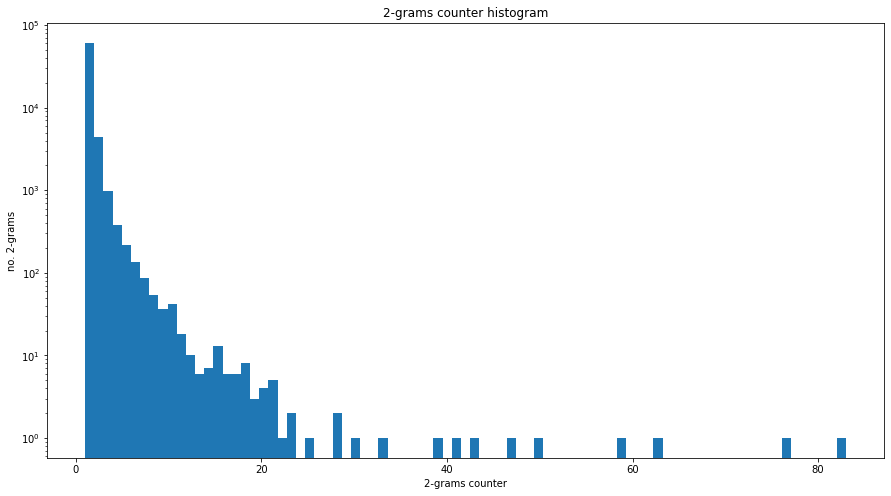

In [8]:
# count 2-grams
two_grams = []
for sentence in hindi_train_df['text']:
    words = sentence.split()
    two_grams.extend([(words[i], words[i+1]) for i in range(len(words)-1)])

gram_counter = Counter(two_grams)
print('some most-common 2-grams:')
print(gram_counter.most_common(5))

# plot 2-gram frequencies
fig, ax = plt.subplots(figsize=(15, 8))
ax.hist(gram_counter.values(), bins=gram_counter.most_common(1)[0][1])
ax.set_title('2-grams counter histogram')
ax.set_xlabel('2-grams counter')
ax.set_ylabel('no. 2-grams')
ax.set_yscale('log')

In [9]:
# at first, we choose threshold = 10, i.e. 2-grams that appear at least 10 times are considered phrases
# however, this doesn't increase accuracy. Maybe because the dataset is too small that statistic inferences are not sound.
# So, we disable 2-grams by setting threshold to 100, i.e. no 2-grams are formed.
two_grams_threshold_occurences = 100

phrases = [grams for grams in gram_counter if gram_counter[grams] >= two_grams_threshold_occurences]

## Vocab and Word <-> int transformation

In [10]:
def split_sentence(sentence):
    words = sentence.split()
    splitted = []
    i = 0
    while i < len(words):
        if (i < len(words) - 1 and (words[i], words[i+1]) in phrases):
            splitted.append('_'.join((words[i], words[i+1])))
            i += 2
        else:
            splitted.append(words[i])
            i += 1
    
    return splitted

train_sentences = [split_sentence(sentence) for sentence in hindi_train_df['text']]
test_sentences = [split_sentence(sentence) for sentence in hindi_test_df['text']]

flattened_words = [word for sentence in train_sentences for word in sentence]
V = sorted(list(set(flattened_words)))
vocab_size = len(V)
print(f'vocab_size: {vocab_size}')

word_to_int = {}
int_to_word = {}
for i, word in enumerate(V):
    word_to_int[word] = i
    int_to_word[i] = word

# save dicts for transformation word <-> int
with open('save/hindi_word_to_int_dict.json', 'w') as f:
    json.dump(word_to_int, f)
with open('save/hindi_int_to_word_dict.json', 'w') as f:
    json.dump(int_to_word, f)    

# save word-counter for sampling
word_counter = Counter(flattened_words)
with open('save/hindi_word_counter.json', 'w') as f:
    json.dump(word_counter, f)

vocab_size: 19379


In [11]:
train_sentences = [[word_to_int[word] for word in sentence] for sentence in train_sentences]
test_sentences = [[word_to_int[word] for word in sentence if word in word_to_int] for sentence in test_sentences]

In [12]:
# exclude empty sentences

train_texts = [' '.join([str(v) for v in l]) for l in train_sentences]
hindi_train_df['text'] = train_texts
hindi_train_df = hindi_train_df[hindi_train_df['text'].str.len() != 0].reset_index(drop=True)

test_texts = [' '.join([str(v) for v in l]) for l in test_sentences]
hindi_test_df['text'] = test_texts
hindi_test_df = hindi_test_df[hindi_test_df['text'].str.len() != 0].reset_index(drop=True)

In [13]:
hindi_train_df.rename(columns={'text':'sentence'}, inplace=True)
hindi_test_df.rename(columns={'text':'sentence'}, inplace=True)

## Save output

In [14]:
display(hindi_train_df.head())
display(hindi_test_df.head())

,text_id,sentence,task_1,task_2,task_3
0,hasoc_hi_5556,13596 17167 16799 14350 1650 15814 16162 253 120,NOT,NONE,NONE
1,hasoc_hi_5648,17600 15743 11530 11086 17053 1448 19075 17600...,HOF,PRFN,UNT
2,hasoc_hi_164,10475 18701 13529 9707 6789 17241 10490 16483 ...,HOF,PRFN,TIN
3,hasoc_hi_3530,13784 3632 5594 16863 9720 16061 9243 15179 78...,NOT,NONE,NONE
4,hasoc_hi_5206,8593 13808 16895 12133 5798 12732 10523 15645 ...,NOT,NONE,NONE


,text_id,sentence,task_1,task_2,task_3
0,hasoc_hi_5061,16688 5897 15598 5726 6754 11324 11068 19029 250,NOT,NONE,NONE
1,hasoc_hi_2090,769 749 11095 11145 15755 14938 14353 7944 157...,HOF,OFFN,TIN
2,hasoc_hi_2960,12283 8038 18798 11030 18681 11068 18648 11559...,HOF,OFFN,TIN
3,hasoc_hi_864,17095 10515 5623 6584 15675 17028 13213 15761 ...,NOT,NONE,NONE
4,hasoc_hi_54,11791 9620 18643 17696 18042 18666 5725 5723 1...,NOT,NONE,NONE


In [15]:
hindi_train_df.to_csv('save/hindi_train_preprocessed.csv', index=False)
hindi_test_df.to_csv('save/hindi_test_preprocessed.csv', index=False)